In [8]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow as gimshow
import os
import albumentations as A
import torch
from typing import List
from copy import deepcopy
# install yolov5 dependencies
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt 


Video sources : 

highway -> <a href="https://pixabay.com/users/mabelamber-1377835/?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=video&amp;utm_content=27260">👀 Mabel Amber, who will one day</a> from <a href="https://pixabay.com//?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=video&amp;utm_content=27260">Pixabay</a> 

Walking <a href="https://pixabay.com/users/coverr-free-footage-1281706/?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=video&amp;utm_content=6387">Coverr-Free-Footage</a> from <a href="https://pixabay.com//?utm_source=link-attribution&amp;utm_medium=referral&amp;utm_campaign=video&amp;utm_content=6387">Pixabay</a>

In [9]:
highway = "/content/drive/MyDrive/object_tracking/car.mp4"
walking = "/content/drive/MyDrive/object_tracking/walking.mp4"

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-11-3 Python-3.7.15 torch-1.12.1+cu113 CPU

Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients
Adding AutoShape... 


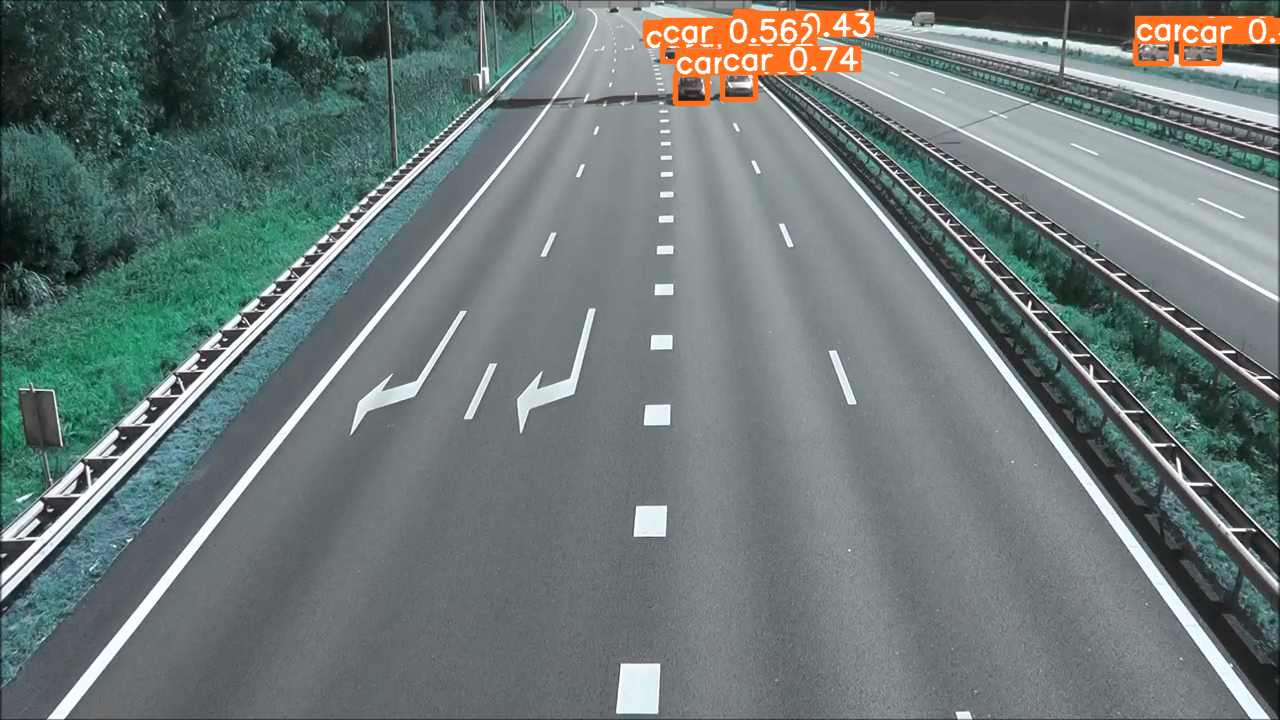

,xmin,ymin,xmax,ymax,confidence,class,name
0,722.609558,71.972923,755.877380,99.946205,0.738950,2,car
1,675.796936,74.188255,707.361511,103.485481,0.662603,2,car
2,662.514343,43.597702,683.892883,61.902313,0.559480,2,car
3,678.343018,21.807419,694.445923,36.869522,0.516248,2,car
4,645.519226,22.989059,661.695374,40.861427,0.486279,2,car
5,1181.850220,43.080643,1219.252563,63.265732,0.483406,2,car
6,735.957336,11.030304,753.734436,27.111801,0.430497,2,car
7,1135.834717,41.129295,1171.845703,63.272530,0.258561,2,car


In [10]:
#@title View the results of YOLOv5
model = torch.hub.load('ultralytics/yolov5', 'yolov5m', pretrained=True)
cap = cv.VideoCapture(highway)

success, frame = cap.read()
assert cap.isOpened(), "file could not be opened"
height, width = frame.shape[:2] # need this later
res = model(frame)
res.show() 

df = res.pandas().xyxy[0] # bbox coordinates
display(df)


In [11]:
#@title Tracking
# use legacy trackers, not sure why the new tracker apis doesn't play well
trackers = cv.legacy.MultiTracker_create()
# trackers ordered (high to low) in terms of speed
mosse = cv.legacy.TrackerMOSSE_create 
kcf = cv.legacy.TrackerMOSSE_create 
csrt = cv.legacy.TrackerCSRT_create 

BBOX_COLOR = (255,255,255)
BBOX_THICKNESS = 2
SCALED_DIM = (640, 480) # 480p

# resize to 480p
def downscale(frame):
  return cv.resize(frame,SCALED_DIM, interpolation = cv.INTER_AREA)

"""
Detect objects using yolo -> track detected objects using opencv trackers
"""
def track(filepath, model, output_name, tracker = kcf):
  # read file
  cap = cv.VideoCapture(filepath)
  success, frame = cap.read()
  assert cap.isOpened(), "file could not be opened"
  height, width = frame.shape[:2] # need this later

  # object detection using yolo
  res = model(frame)
  df = res.pandas().xyxy[0] # bbox coordinates

  for index, row in df.iterrows():
    # open cv operates in int8
    xmin, ymin, xmax, ymax = int(row.xmin), int(row.ymin), int(row.xmax), int(row.ymax)
    
    # format into [x,y, w, h] for tracker
    bbox = (xmin, ymin, xmax-xmin, ymax-ymin)
    trackers.add(tracker(), frame, bbox)

  img_array = []
  while True:
    if frame is None:
      break
    
    tracked, bboxes = trackers.update(frame)

    # all tracking failed, we can stop now
    if sum(map(lambda x: any(x), bboxes)) == 0: 
      break
    
    # draw bboxes
    for bbox in bboxes:
      if any(bbox): # tracked
        # draw bounding boxes
        (x, y, xs, ys) = tuple(map(lambda x : int(x), bbox))
        cv.rectangle(frame, 
                    (x,y), 
                    (x+xs, y+ys), 
                    BBOX_COLOR, 
                    BBOX_THICKNESS)
    
    frame = downscale(frame)
    img_array.append(frame)
    _, frame = cap.read()

  cap.release()

  # create file
  codec = cv.VideoWriter_fourcc(*"MJPG")
  out = cv.VideoWriter(f"{output_name}.avi", codec, 15, SCALED_DIM) # 480p
  for img in img_array:
    out.write(img)
  out.release()


In [12]:
%%time
track(highway, model = model, output_name = "output_highway")
track(walking, model = model, output_name = "output_walking")

CPU times: user 35.7 s, sys: 665 ms, total: 36.4 s
Wall time: 32.9 s


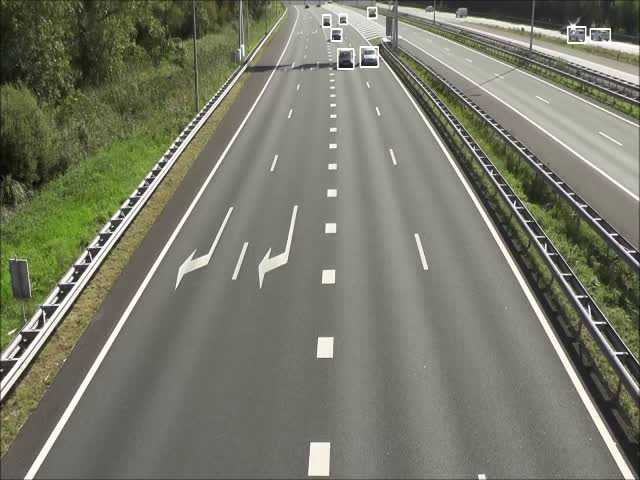

In [13]:
# testing if the writing was success
## download to view
cap = cv.VideoCapture("output_highway.avi")
assert cap.isOpened(), "file could not be opened"
ret, frame = cap.read()
gimshow(frame)
cap.release()